In [1]:
"""
Notebook to eventually run all the regression modelling process (exlcudes NTS data prcoessing)
v0.1 - 13/05/2024, JN - Originated
v0.2 - 13/05/2024, ART - Checking and switch to Ridge model
     - 14/05/2024, ART - Further checking
v0.3 - 15/05/2024, ART - Adding further input control and education data
     - 16/05/2024, ART - Picking up changes made in (forked) v0.2 version late on 15/05 (output renaming)
     - 16/05/2024, ART - Completed implementation of education, added switch to turn purposes on and off
     - 16/05/2024, ART - Picked up further file name corrections from the (forked) v0.2 version following CLFL comments
v0.3_M6.18p - 16/05/2024, ART - Setting up to run Model 6.18 in python - Commute/Employer's Business only
v0.3_M6.19p - 16/05/2024, ART - Setting up to run Model 6.19 in python - Employer's Business only
v0.3_M6.20p - 16/05/2024, ART - Setting up to run Model 6.20 in python - Shopping only
v0.3_M6.21p - 16/05/2024, ART - Setting up to run Model 6.20 in python - Personal Business only
v0.4 - 16/05/2024, ART - Altering selection conditions to allow single notebook to run all purposes 'finalised' so far
     - 20/05/2024, ART - More SOC selection condition improvements
                         Allows purpose-based selection of Area Type Grouping
                         Allows multiple SIC codes to be grouped to a single coefficient (per Area Type Grouping)
v0.5 - 21/05/2024, ART - Adding Visit Friends purpose using Household data, renaming AT grouping to versioned options
v0.6 - 21/05/2024, ART - Debugging education when aggregating with the pupil-based data
                         Correcting SIC/Education data join that was working incorrectly
                         Setting education LSOA to MSOA correspondences to better match what is in the datasets
                         Note there appears to be issues with the Wales Further Education Data at source
v0.7 - 22/05/2024, ART - Additional output file - all coeffs in one file
                         Fields: Purpose (1-8), Area type grouping, SOC(named combination/all), SIC code, Coefficient
                         General tidying
v0.8 - 23/05/2024, ART - Reformatting combined coefficient output file to
                         Fields: Purpose (1-8), Area Type (1-20), SOC(1-4), SIC code/Data, Coefficient
TRANSFER TO GIT AND RENAMED FROM: build_attractions_Fullpipeline_v0.8.ipynb
                              TO: build_attractions.ipynb
                              ART, 23/05/2024
"""

"\nNotebook to eventually run all the regression modelling process (exlcudes NTS data prcoessing)\nv0.1 - 13/05/2024, JN - Originated\nv0.2 - 13/05/2024, ART - Checking and switch to Ridge model\n     - 14/05/2024, ART - Further checking\nv0.3 - 15/05/2024, ART - Adding further input control and education data\n     - 16/05/2024, ART - Picking up changes made in (forked) v0.2 version late on 15/05 (output renaming)\n     - 16/05/2024, ART - Completed implementation of education, added switch to turn purposes on and off\n     - 16/05/2024, ART - Picked up further file name corrections from the (forked) v0.2 version following CLFL comments\nv0.3_M6.18p - 16/05/2024, ART - Setting up to run Model 6.18 in python - Commute/Employer's Business only\nv0.3_M6.19p - 16/05/2024, ART - Setting up to run Model 6.19 in python - Employer's Business only\nv0.3_M6.20p - 16/05/2024, ART - Setting up to run Model 6.20 in python - Shopping only\nv0.3_M6.21p - 16/05/2024, ART - Setting up to run Model 6.2

# Import libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import sklearn
from scipy.optimize import minimize, rosen, rosen_der
import seaborn as sns
sns.set_style('whitegrid')

# Model Details and Set Up

In [3]:
# Model name
model_name = 'TestingPython'

# Model version
model_version = 'output'

# Model directory
modeldirname = '_'.join(['Output_attractions', model_name, model_version])

# NTS data direction selection
nts_direction = 'hb_fr' # Can be 'hb_fr' OR 'nhb'

# Select which purposes to run for (overwrites everything below)
    # Options are "On" or "Off"
    # If not "On" then purpose dropped
purpose_inclusion = {
    "Commute": "On",
    "Employer's Business": "On",
    "Education": "On",
    "Shopping": "On", 
    "Personal Business": "On",
    "Social": "On",
    "Visit Friend": "On",
    "Holiday": "On"
}

# Set the Area Type classifcations by purpose
    # - Note if a purpose is not assigned an Area Type here, it is dropped!
    # - Each Area Type classifcation here must be defined in a cell further down
    # - If an acitve purpose is listed twice, the output will be generated once for each AT classification system it is in
    # - Active purposes listed twice will generate a warning, as will active purposes not listed at all
    # - Each Area Type grouping is assigned a list of purposes
    # - If there are no purposes for a grouping, the list should be empty
at_purp_classifcation = {
    "none": [],
    "grouped_v1": [],
    "grouped_v2": ["Commute", "Employer's Business", "Education", "Shopping", "Personal Business", "Visit Friend"],
    "grouped_v3": ["Social", "Holiday"],
    "individual": []
}

# SOC selection for purposes that require it.
    # - Assume this will just be Commute/Employer's Business
    # - Some purposes like education and visit friends may not behave as expected if incuded here
    # - ONLY include purposes where SOC selection is required
    # - Allowed values 1 to 4
    # - Ints in a list will output results by individual SOC
    # - Lists in a list will output results by grouped SOC for SOCs in the sub-list
    # - To "select all" (i.e. not filter by SOC and generate a single coefficient) remove from dict or input [[1, 2, 3, 4]]
purposes_with_soc_selection = {
    "Commute": [1, 2, 3],
    "Employer's Business": [1, [2, 3]]
}

# Select education parameters
edu_aggregation = False # Can be False (as many coeffs as inputs) OR True (1 coeff) - Recommended to leave as False to avoid summing employment to students. Setting to True also overwrites pupil_aggregation
pupil_aggregation = False # Can be False (as many coeffs as levels of edu in pupil data) OR True (1 coeff from pupil data). Overwritten if edu_aggregation == True
sic_education = [85] # Can be empty list [] for no SIC data OR a list of 1 or more 2 digit SIC codes (as int) for SIC data
pupil_education = {'pupil': 'Keep',
                   'higher': 'Keep',
                   'further': 'Keep'} # 'Keep' to use level of edu from pupil data, 'Drop' to exclude it (all set to 'Drop' permitted)

# Create education correspondence to pass to purpose list
education_correspondence = sic_education.copy()
for level, status in pupil_education.items():
    if status == 'Keep':
        education_correspondence.append(str(level))

# Set Visit Friend parameters - the type of visit friend
visit_friend_data = {'households': 'Keep',
                     'population': 'Drop'} # 'Keep' to use these data in Visit Friend, 'Drop' to exclude it. Expected to be one or the other, not both

visit_friend_correspondence = []
for data, status in visit_friend_data.items():
    if status == 'Keep':
        visit_friend_correspondence.append(str(data))

# Set the purpose correspondence
    # If a purpose is turned "On" in purpose_inclusion, it MUST be in this list
    # If a purpose is turned "Off" in purpose_inclusion, any value corresponding to it in this dictonary will be ignored
    # "All_SICs" for all SIC purposes
    # [int, ..., int] (list of ints corresponding to SIC 2 digit codes) to select those 2 digit codes in SIC data
        # Each individual int here creates a set of coefficients for each group of Area Types
        # Sub lists of ints laso allowed here - these will aggregate SICs within the sublist to a single coefficient per AT group
    # "Education" to use the education selection above
    # "Visit Friend" TODO
correspondence_list_purpose = {
    "Commute": "All_SICs",
    "Employer's Business": "All_SICs",
    "Education": education_correspondence,
    "Shopping": [45, 47], 
    "Personal Business": [75, 77, 86, 96],
    "Social": [56, 91, 93],
    "Visit Friend": visit_friend_correspondence,
    "Holiday": [55]
}

# Read input data

In [4]:
# Set up paths, file names and working directory
rootdir = 'I:/NTS/NorMITs WP1/Built Attractions'
inputdirname = 'Input'
edudirname = 'Data/Input'
ntsdirname = 'PythonTesting'

inputdirpath = os.path.join(rootdir, inputdirname)
edudirpath = os.path.join(rootdir, edudirname)
ntsdirpath = os.path.join(rootdir, ntsdirname)
modeldirpath = os.path.join(rootdir, modeldirname)

if not os.path.exists(modeldirpath):
    os.makedirs(modeldirpath)

lsoatomsoaname = 'LSOA21toMSOA 2011Lookup.csv' # Generated by AtkinsRealis from the shape file shared by TfN in Y:\Data Strategy\GIS Shapefiles\NorMITs 2024 zone system\GB LSOA2021 and DZ2011 Clipped
lsoa2011tomsoaname = 'msoa_to_lsoa_correspondence.csv'
msoatoatname = 'uk_msoa_iz_2011_area_types.csv' # From TfN
msoatouaname = 'msoa_ua1998_lookup.csv' # From TfN
ntsname = 'NTS_Data_Processed_v0.5.csv' # Processed by AtkinsRealis
socsicpath = 'I:/NorMITs Land Use/import/SOC mix/soc_2_digit_sic_2018.csv' # From TfN
hhpoppath = 'I:/NorMITs Land Use/base_land_use/iter4k/01 Process/3.2.4_land_use_formatting/resi_property_msoa_agg_prt_2018_dwells+pop.csv' # From TfN
msoatogorpath = 'I:/Data/Zone Translations/msoa_to_gor_correspondence.csv' # From TfN

# Education paths - All as provided by TfN
eduengpupilpath = 'spc_school_level_underlying_data_lsoa21_202223.csv'# Uses 2021 LSOA
eduscopupilpath = 'pupils22_scotland_dz2011.csv'# Uses 2021 LSOA
eduwalpupilpath = 'wales_lsoa-floorspace_pupils22.csv'# Uses 2021 LSOA
eduengfepath = 'further_education_england_202223.csv' # Uses 2011 (but labelled as 2021) LSOA
eduscofepath = 'further_education_scotland_202122.csv'# Uses 2011 (but labelled as 2021) LSOA
eduwalfepath = 'further_education_wales_202122.csv'# Uses 2021 LSOA - does not match other FE LSOA years. Has issues with data back to TfNs source
edugbhepath = 'higher_education_202122.csv' # Uses 2021 LSOA

In [5]:
# Read in the data - lookups
df_msoaTolsoa = pd.read_csv(os.path.join(edudirpath, lsoatomsoaname)) # The 2021 LSOA to 2011 MSOA correspondence is in here
df_lsoa2011Tomsoa = pd.read_csv(os.path.join(edudirpath, lsoa2011tomsoaname)) # Required as Further Education (England and Scotland) is by 2011 LSOA
df_msoatoatlookup_in = pd.read_csv(os.path.join(inputdirpath, msoatoatname))
df_msoaUAlookup = pd.read_csv(os.path.join(inputdirpath, msoatouaname))
df_msoatogorlookup = pd.read_csv(msoatogorpath)

# NTS Data
df_nts = pd.read_csv(os.path.join(ntsdirpath, ntsname)).drop(['Unnamed: 0'], axis=1) # Drop old index column

# Employment Data
df_socsic = pd.read_csv(socsicpath)

# Visit Friends Data
df_hhpop = pd.read_csv(hhpoppath)

# Education Data
df_pupilEngland = pd.read_csv(os.path.join(edudirpath, eduengpupilpath))
df_pupilScotland = pd.read_csv(os.path.join(edudirpath, eduscopupilpath))
df_pupilWales = pd.read_csv(os.path.join(edudirpath, eduwalpupilpath))
df_furthereduEngland = pd.read_csv(os.path.join(edudirpath, eduengfepath))
df_furthereduScotland = pd.read_csv(os.path.join(edudirpath, eduscofepath))
df_furthereduWales = pd.read_csv(os.path.join(edudirpath, eduwalfepath))
df_higheredugb = pd.read_csv(os.path.join(edudirpath, edugbhepath))

# Inital checks and processing

## Check Area Type Grouping by Purpose and Main Purpose selection match

In [6]:
# Sort out purpose selection
purposesUsed = []
for key, value in purpose_inclusion.items():
    if value != "On":
        # Remove purposes that are not "On" from the dictonary that sets the processing
        del correspondence_list_purpose[key]
        purposesUsed.append(key)

# Check purpose to AT grouping and flag issues
checkedPurposesByATgroup = []
for grouping in at_purp_classifcation:
    for purpose in at_purp_classifcation[grouping]:
        if purpose not in checkedPurposesByATgroup:
            checkedPurposesByATgroup.append(purpose)
        else:
            print(f'WARNING! - Purpose "{purpose}" appears twice in the purpose to Area Type grouping allocation')
            print(f'This will generate multiple outputs for the {purpose} purpose')
for purposeU in purposesUsed:
    if purposeU not in checkedPurposesByATgroup:
        print(f'WARNING! - Purpose "{purpose}" is not assigned an Area Type grouping, but is supposedly active')
        print(f'As the Area Type grouping to which to assign the {purpose} purpose is unknown, it will be dropped')

## Initial data processing, independent of Area Type Grouping

### Lookup processing that is independent of Area Type Grouping

In [7]:
df_msoaUAlookup = df_msoaUAlookup[['msoa_zone_id','ua_1998_zone_id']]
df_msoaTolsoa = df_msoaTolsoa[['msoa11cd', 'lsoa21cd']]
df_msoaTolsoa['msoa11cd'] = df_msoaTolsoa['msoa11cd'].str.split('/').str[0] # As some MSOAs in the data have a '/' in them seperating two options for a single LSOA (2021 LSOA correspondence only)
df_msoaTolsoa = df_msoaTolsoa.rename(columns={'lsoa21cd': 'lsoa'})
df_lsoa2011Tomsoa = df_lsoa2011Tomsoa[['lsoa_zone_id', 'msoa_zone_id']]
df_lsoa2011Tomsoa = df_lsoa2011Tomsoa.rename(columns={'lsoa_zone_id': 'lsoa', 'msoa_zone_id': 'msoa11cd'})

# Create UA to GOR lookup - can be dropped if the inital NTS processing is made part of this workbook
# Used to reattach GOR to output dfs without risk of odd things happening to it in groupbys
df_ua_to_gor = df_msoatogorlookup.merge(
    df_msoaUAlookup[['msoa_zone_id', 'ua_1998_zone_id']],
    on='msoa_zone_id',
    how='outer'
)[['ua_1998_zone_id', 'gor']].drop_duplicates().reset_index(drop=True)

# Do the preliminary processing on the Visit Friends dataset
df_hhpop_trips = df_hhpop.rename(columns={'ZoneID':'msoa_zone_id'})
df_hhpop_trips['households'] = df_hhpop_trips['population'] / df_hhpop_trips['household_occupancy_18']
df_hhpop_trips = df_hhpop_trips.groupby(['msoa_zone_id'])[['population', 'households']].sum().reset_index()
df_hhpop_trips = df_hhpop_trips.merge(df_msoaUAlookup, on='msoa_zone_id', how='inner')
df_hhpop_trips = df_hhpop_trips.rename(columns={'msoa_zone_id': 'msoa11cd'})
# df_hhpop_trips = df_hhpop_trips.groupby(['ua_1998_zone_id'])[['population', 'number_of_households']].sum().reset_index()

# Rename the msoa_zone_id column now we have used it in the GOR lookup
df_msoaUAlookup_ren = df_msoaUAlookup.rename(columns={'msoa_zone_id': 'msoa11cd'})

### NTS data processing

In [8]:
# Dictionary for renaming NTS purpose codes
correspondence_list_purpose_name = {
    1: "Commute",
    2: "Employer's Business",
    3: "Education",
    4: "Shopping",
    5: "Personal Business",
    6: "Social",
    7: "Visit Friend",
    8: "Holiday"
}

# Get purpose (and SOC where valid) together as a column
df_nts['purpose_name'] = df_nts['purpose'].map(correspondence_list_purpose_name)

# Create purpose_SOC column for purposes that may require it
df_nts['purpose_SOC'] = np.where(df_nts['purpose_name'].isin(purposes_with_soc_selection),
                                 df_nts['purpose_name'].astype(str) + df_nts['soc'].astype(str),
                                 df_nts['purpose_name'].astype(str))

### Education data processing

In [9]:
def education_lsoa_msoa_join(education_df, lsoayear):
    if lsoayear == 2011:
        education_df = education_df.merge(df_lsoa2011Tomsoa, on='lsoa', how='inner')
    else:
        if  lsoayear != 2021:
            print(f'WARNING! - Only 2011 and 2021 are valid lsoa years here, not: {str(lsoayear)}')
            print('Defaulting to 2021 - CHECK YOUR OUTPUTS AS ROWS ARE LIKELY TO HAVE BEEN DROPPED UNEXPECTEDLY')
        education_df = education_df.merge(df_msoaTolsoa, on='lsoa', how='inner')
    education_df = education_df.drop(columns=['lsoa'], axis=1)
    education_df = education_df.groupby(['msoa11cd']).sum()
    
    return education_df

In [10]:
# Rename columns in input data to get a consistent standard and create the GB dataframes (where required)

# As different levels of education by geography use different LSOA numbering systems, this is required
edu_lsoa_year_lookup = {
    'Pupils England': 2021,
    'Pupils Scotland': 2021,
    'Pupils Wales': 2021,
    'Further England': 2011,
    'Further Scotland': 2011,
    'Further Wales': 2021, # Odd one out in further education. Does not appear to have been processed correctly prior to input here as of 21/05/2024
    'Higher GB': 2021
}

df_pupilEngland = df_pupilEngland.rename(columns={'lsoa21cd': 'lsoa', 'fte pupils': 'pupils'})
df_pupilWales = df_pupilWales.rename(columns={'lsoa21cd': 'lsoa'})
df_pupilEngland = education_lsoa_msoa_join(df_pupilEngland, edu_lsoa_year_lookup['Pupils England'])
df_pupilScotland = education_lsoa_msoa_join(df_pupilScotland, edu_lsoa_year_lookup['Pupils Scotland'])
df_pupilWales = education_lsoa_msoa_join(df_pupilWales, edu_lsoa_year_lookup['Pupils Wales'])
df_pupilGB = pd.concat([df_pupilEngland, df_pupilScotland, df_pupilWales], axis=0)
df_pupilGB = df_pupilGB.rename(columns={'pupils': 'student_count'})

df_furthereduEngland = df_furthereduEngland.rename(columns={'lsoa21cd': 'lsoa'})
df_furthereduWales = df_furthereduWales.rename(columns={'lsoa21cd': 'lsoa', 'Sum of dist_fe': 'fe_students'})
df_furthereduEngland = education_lsoa_msoa_join(df_furthereduEngland, edu_lsoa_year_lookup['Further England'])
df_furthereduScotland = education_lsoa_msoa_join(df_furthereduScotland, edu_lsoa_year_lookup['Further Scotland'])
df_furthereduWales = education_lsoa_msoa_join(df_furthereduWales, edu_lsoa_year_lookup['Further Wales'])
df_feGB = pd.concat([df_furthereduEngland, df_furthereduWales, df_furthereduScotland], axis=0)
df_feGB = df_feGB.rename(columns={'fe_students': 'student_count'})

df_highereduGB = df_higheredugb.rename(columns={'lsoa21cd': 'lsoa', 'he_students': 'student_count'})
df_highereduGB = education_lsoa_msoa_join(df_highereduGB, edu_lsoa_year_lookup['Higher GB'])

# Main Process

## Functions called in Main Process

### Select Area Type Grouping correspondance table

In [11]:
def get_AT_grouping_table(atGroupingName):
        if atGroupingName == 'grouped_v1':
            corr_list_at = {
                1: 'Group_1-8',
                2: 'Group_1-8',
                3: 'Group_1-8',
                4: 'Group_1-8',
                5: 'Group_1-8',
                6: 'Group_1-8',
                7: 'Group_1-8',
                8: 'Group_1-8',
                9: 'Group_9-15',
                10: 'Group_9-15',
                11: 'Group_9-15',
                12: 'Group_9-15',
                13: 'Group_9-15',
                14: 'Group_9-15',
                15: 'Group_9-15',
                16: 'Group_16-17',
                17: 'Group_16-17',
                18: 'Group_18_19',
                19: 'Group_18_19',
                20: 'Group_20'
            }
        elif atGroupingName == 'grouped_v2':
            corr_list_at = {
                1: 'Group_1,3,16',
                2: 'Group_2,6,8,17,19,20',
                3: 'Group_1,3,16',
                4: 'Group_4,5,7,14,15',
                5: 'Group_4,5,7,14,15',
                6: 'Group_2,6,8,17,19,20',
                7: 'Group_4,5,7,14,15',
                8: 'Group_2,6,8,17,19,20',
                9: 'Group_9,10,11,12,13',
                10: 'Group_9,10,11,12,13',
                11: 'Group_9,10,11,12,13',
                12: 'Group_9,10,11,12,13',
                13: 'Group_9,10,11,12,13',
                14: 'Group_4,5,7,14,15',
                15: 'Group_4,5,7,14,15',
                16: 'Group_1,3,16',
                17: 'Group_2,6,8,17,19,20',
                18: 'Group_18',
                19: 'Group_2,6,8,17,19,20',
                20: 'Group_2,6,8,17,19,20'
            }
        elif atGroupingName == 'grouped_v3':
            corr_list_at = {
                1: 'Group_1,3,16',
                2: 'Group_2,6,8,17,18,19,20',
                3: 'Group_1,3,16',
                4: 'Group_4,5,7,14,15',
                5: 'Group_4,5,7,14,15',
                6: 'Group_2,6,8,17,18,19,20',
                7: 'Group_4,5,7,14,15',
                8: 'Group_2,6,8,17,18,19,20',
                9: 'Group_9,10,11,12,13',
                10: 'Group_9,10,11,12,13',
                11: 'Group_9,10,11,12,13',
                12: 'Group_9,10,11,12,13',
                13: 'Group_9,10,11,12,13',
                14: 'Group_4,5,7,14,15',
                15: 'Group_4,5,7,14,15',
                16: 'Group_1,3,16',
                17: 'Group_2,6,8,17,18,19,20',
                18: 'Group_2,6,8,17,18,19,20',
                19: 'Group_2,6,8,17,18,19,20',
                20: 'Group_2,6,8,17,18,19,20'
            }
        elif atGroupingName == 'individual':
            corr_list_at = {
                1: 'Group_1',
                2: 'Group_2',
                3: 'Group_3',
                4: 'Group_4',
                5: 'Group_5',
                6: 'Group_6',
                7: 'Group_7',
                8: 'Group_8',
                9: 'Group_9',
                10: 'Group_10',
                11: 'Group_11',
                12: 'Group_12',
                13: 'Group_13',
                14: 'Group_14',
                15: 'Group_15',
                16: 'Group_16',
                17: 'Group_17',
                18: 'Group_18',
                19: 'Group_19',
                20: 'Group_20'
            }
        else:
            if atGroupingName != 'none':
                print(f'WARNING! - Unknown at_classification: {str(atGroupingName)}')
                print("Defaulting to to AreaType Grouping 'None'")
            corr_list_at = {
                1: 'Group_All',
                2: 'Group_All',
                3: 'Group_All',
                4: 'Group_All',
                5: 'Group_All',
                6: 'Group_All',
                7: 'Group_All',
                8: 'Group_All',
                9: 'Group_All',
                10: 'Group_All',
                11: 'Group_All',
                12: 'Group_All',
                13: 'Group_All',
                14: 'Group_All',
                15: 'Group_All',
                16: 'Group_All',
                17: 'Group_All',
                18: 'Group_All',
                19: 'Group_All',
                20: 'Group_All'
            }
        
        return corr_list_at

### Employment data processing

In [12]:
# Define sub functions used in the all_purposes_sics function

def get_sic_formatted(df_sic, sic_val):
    # Doing the grouping and column renaming of the SIC table
    df_sic = df_sic.groupby(['ua_1998_zone_id', 'ATgroup']).sum('seg_jobs').reset_index()
    df_sic = df_sic[['ua_1998_zone_id', 'ATgroup', 'seg_jobs']]
    df_sic = df_sic.pivot_table(index=['ua_1998_zone_id'], columns=['ATgroup'],
                                values='seg_jobs', aggfunc='sum').reset_index()
    df_sic.fillna(0, inplace=True)
    # Loop through each column in the DataFrames
    for col in df_sic.columns:
        # Check if it is the column to be excluded
        if col != 'ua_1998_zone_id':
            # Prefix the string to the column name
            df_sic.rename(columns={col: sic_val + col}, inplace=True)
    
    return df_sic

def get_nts_formatted(df_nts_filtered, purpose_name, col_search):
    # No SIC data in the NTS table, so no need to filter for that
    # Does use SOC, so needs passing the SOC filtered table
    # Also uses purpose, so needs passing purpose (incl. SOC when SOC is in)
    df_nts_filtered = df_nts_filtered[df_nts_filtered['direction'] == nts_direction]
    if type(purpose_name) is list: # A case when SOC filtering is occuring
        df_nts_filtered = df_nts_filtered[df_nts_filtered[col_search].isin(purpose_name)]
    else:
        df_nts_filtered = df_nts_filtered[df_nts_filtered[col_search] == purpose_name]
    df_nts_filtered = df_nts_filtered.groupby(['ua_1998_zone_id'])['expanded_trips'].sum().reset_index()
    df_nts_filtered['ua_1998_zone_id'] = df_nts_filtered['ua_1998_zone_id'].astype(int)
    
    return df_nts_filtered
    
def merge_dataframes(df_list, column_name):
    merged_df = df_list[0] # Get the first DataFrame in the list
    # Merge all other DataFrames in the list based on the column
    for i in range(1, len(df_list)):
        merged_df = pd.merge(merged_df, df_list[i], on=column_name)

    return merged_df

def sic_processing(df_sic_p, sic_selection):
    if sic_selection == 'All':
        val = 'AllSICs_'
        sic_output_data = get_sic_formatted(df_sic_p, val) # Process SIC data
    else:
        dfs = []    
        for value in sic_selection:
            if type(value) is list:
                df_sicx_p = df_sic_p[df_sic_p['sic_2d'].isin(value)] # Filter to a list of SICs to be grouped
                val = ''.join(['SICs', '+'.join(value), '_'])
            else:
                df_sicx_p = df_sic_p[df_sic_p['sic_2d'] == value] # Filter to each SIC indivdually
                val = ''.join(['SIC', str(value), '_'])
            df_sicx_p = get_sic_formatted(df_sicx_p, val) # Process SIC data
            dfs.append(df_sicx_p)
        sic_output_data = merge_dataframes(dfs, 'ua_1998_zone_id') # Merge individual SIC dfs back together by purpose
            
    return sic_output_data

In [13]:
def all_purpose_sics(purpose, purposesoc, sic, df_socsicx):
    if type(purposesoc) is list: # Will only occur when disagg of SOC is true for disagrable purposes
        socs = []
        for purpsoc in purposesoc:
            socs.append(int(purpsoc[-1]))
        df_sic_px =  df_socsicx[df_socsicx['soc_class'].isin(socs)]
        df_nts_p = get_nts_formatted(df_nts, purposesoc, 'purpose_SOC') # Process NTS data (excludes SIC, so can be done now)
        df_sic_processed = sic_processing(df_sic_px, sic)
        df_final = df_nts_p.merge(df_sic_processed, on='ua_1998_zone_id', how='left')
    
    else:
        df_nts_p = get_nts_formatted(df_nts, purpose, 'purpose_name') # Process NTS data (excludes SIC, so can be done now)
        df_sic_processed = sic_processing(df_socsicx, sic)
        df_final = df_nts_p.merge(df_sic_processed, on='ua_1998_zone_id', how='left')
        
    return df_final

### Education data processing

In [14]:
# Set up a function to process each level of education to UA level with applied TfN AT grouping
def process_edu_by_level(df_edulevelGB, colprefix):
    # Merge additional geographies onto df
    # NOTE: These merges are NOT lossless. Possibility that msoa/lsoa codes not consisently from the same year
#     df_edulevelGB = df_edulevelGB.merge(df_msoaTolsoa, on='lsoa', how='left') # Moved this line to initial processing
    df_edulevelGB = df_edulevelGB.merge(df_msoaUAlookup_ren, on='msoa11cd', how='left')
    df_edulevelGB = df_edulevelGB.merge(df_msoatoatlookup, on='msoa11cd', how='left')
    df_edulevelGB.drop(columns=['msoa11cd'], inplace=True)
    
    # Reshape data to required format
    df_edulevelGB = df_edulevelGB.groupby(['ua_1998_zone_id', 'ATgroup']).sum('student_count').reset_index()
    df_edulevelGB = df_edulevelGB.pivot_table(index=['ua_1998_zone_id'], columns=['ATgroup'],
                                              values='student_count', aggfunc='sum').reset_index()
    df_edulevelGB = df_edulevelGB.rename_axis(None, axis=1)
    
    # Label columns as required
    columns_to_prefix = [col for col in df_edulevelGB.columns if col != 'ua_1998_zone_id']
    prefixed_columns = [f'{colprefix}_{col}' for col in columns_to_prefix]
    new_columns = {old_col: new_col for old_col, new_col in zip(columns_to_prefix, prefixed_columns)}
    df_edulevelGB = df_edulevelGB.rename(columns=new_columns)
    df_edulevelGB.fillna(0, inplace=True)
    df_edulevelGB['ua_1998_zone_id'] = df_edulevelGB['ua_1998_zone_id'].astype(int)
    
    # Drop UAs that are Scottish Islands. Seemingly missing from Employment Data, so make joins tricky
    # Very remote areas (Shetland, Orkney and Western Isles), so unlikely to have a large impact on results
    df_edulevelGB = df_edulevelGB.loc[~df_edulevelGB['ua_1998_zone_id'].isin([724, 727, 732])]
    
    df_edulevelGB = df_edulevelGB.set_index(['ua_1998_zone_id']) # required for concats/joining etc. after this function
    
    return df_edulevelGB

### Regression modelling

In [15]:
def regressions(df_regression, tsoc, tpurp):
    df_regression = df_regression.merge(df_ua_to_gor, on='ua_1998_zone_id', how='left')
    columns_to_drop = ['expanded_trips', 'gor', 'ua_1998_zone_id']
    X = df_regression.drop(columns=columns_to_drop, axis=1)
    y = df_regression['expanded_trips'] # select the y column from the dataframe

    # Instantiate the Ridge regression model with a specific alpha value
    linear_regression = LinearRegression(positive = True, fit_intercept = False) # set the desired alpha value
    # ridge_model = Ridge(alpha=1.0, fit_intercept=False, positive=True) # set the desired alpha value (currently 1.0, the default)
    # Note that R model had alpha=0 which supposedly is the same as doing the basic "linear regression" model in Python

    # Fit the model to the data
    # ridge_model.fit(X, y)
    # predicted_values = ridge_model.predict(X)
    linear_regression.fit(X, y)
    predicted_values = linear_regression.predict(X)
    predicted_values
    df_regression['predicted_values'] = predicted_values

    # coefficients = ridge_model.coef_
    coefficients = linear_regression.coef_
    df_regression_variables = df_regression.drop(columns=columns_to_drop, axis=1)
    coefficients_df = pd.DataFrame(
        zip(df_regression_variables.columns, linear_regression.coef_),
        columns=['Feature', 'Coefficient']
    )
    
    X = df_regression[['expanded_trips']]
    y = df_regression['predicted_values']

    # Scatter plot
    # plt.scatter(X, y)

    # Fit the linear model
    # model = Ridge(alpha=1.0, fit_intercept=False, positive=True)
    model = LinearRegression(fit_intercept=False, positive=True)
    model.fit(X, y)

    # Get the slope and r square
    slope = model.coef_[0]
    r_square = model.score(X, y)

    # Plotting
    plottitle = ''.join(['Model ', model_name, ' ', model_version, '; SOC: ', tsoc, '; Purpose: ', tpurp])
    plotfname = plottitle.replace(';', '')
    plotfname = plotfname.replace(':', '')
    plotfname = plotfname.replace(' ', '_')
    fig, ax = plt.subplots(figsize=(15,8))
    sns.lineplot(x=df_regression['expanded_trips'], y=model.predict(X), ax=ax, color='black') # Plot the linear fit line
    sns.scatterplot(data=df_regression, x='expanded_trips', y='predicted_values', hue='gor', ax=ax) # Plot data and colour by GOR
    tl = ((ax.get_xlim()[1] - ax.get_xlim()[0])*0.010 + ax.get_xlim()[0],
          (ax.get_ylim()[1] - ax.get_ylim()[0])*0.95 + ax.get_ylim()[0])
    ax.text(tl[0], tl[1], r"$R^2 = {}, Slope = {}$".format(round(r_square, 2), round(slope, 2)), fontsize=14)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, title='GOR')
    plt.title(plottitle, fontsize=17)
    plt.savefig(os.path.join(modeldirpath, ''.join([plotfname, '.png'])))  # Save as PNG
    # plt.savefig(os.path.join(modeldirpath, ''.join([plottitle, '.jpeg'])))  # Save as JPEG
    plt.show()
    
    # Save out coefficient data
    coeff_fname = '_'.join([model_name, model_version, tpurp, tsoc, 'coeffs.csv'])
    coefficients_df.to_csv(os.path.join(modeldirpath, coeff_fname), index=False)
    
    return coefficients_df

## Run Main Process

['Commute1']


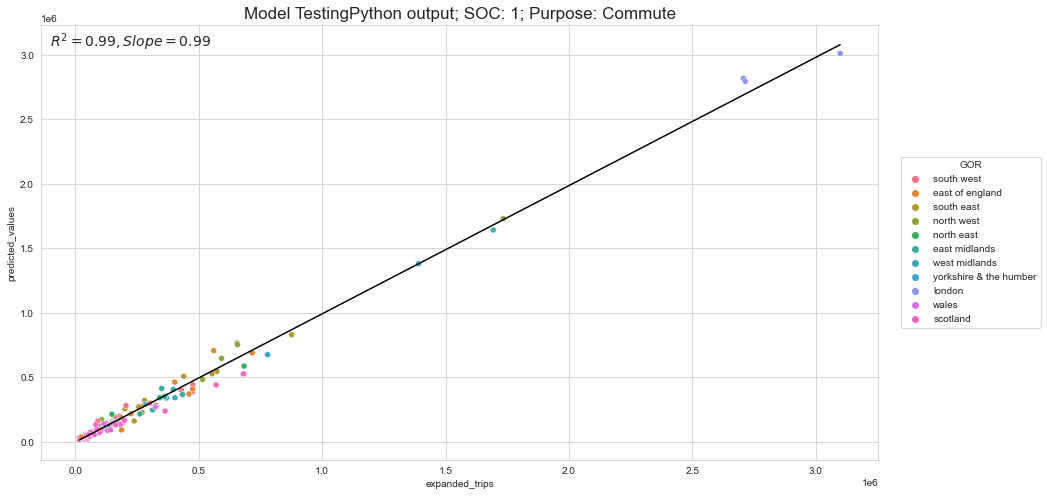

['Commute2']


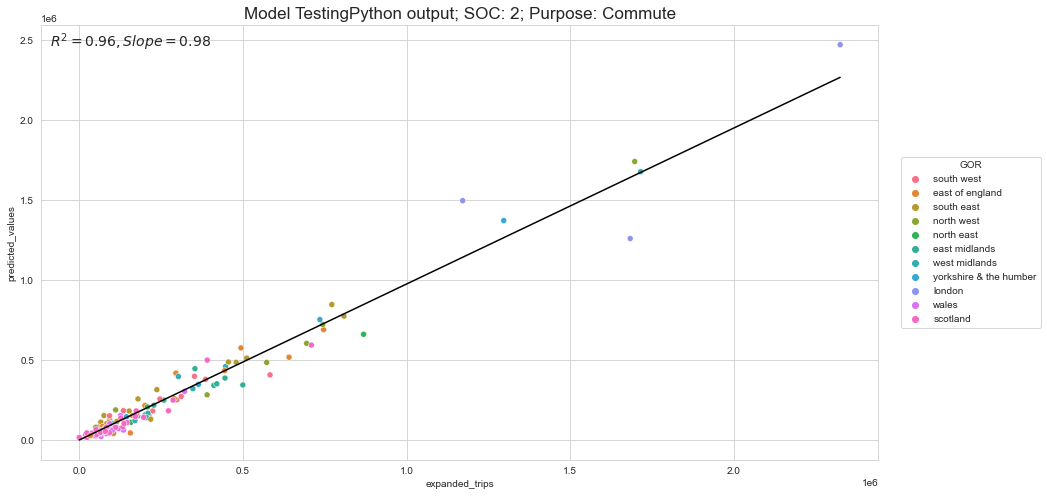

['Commute3']


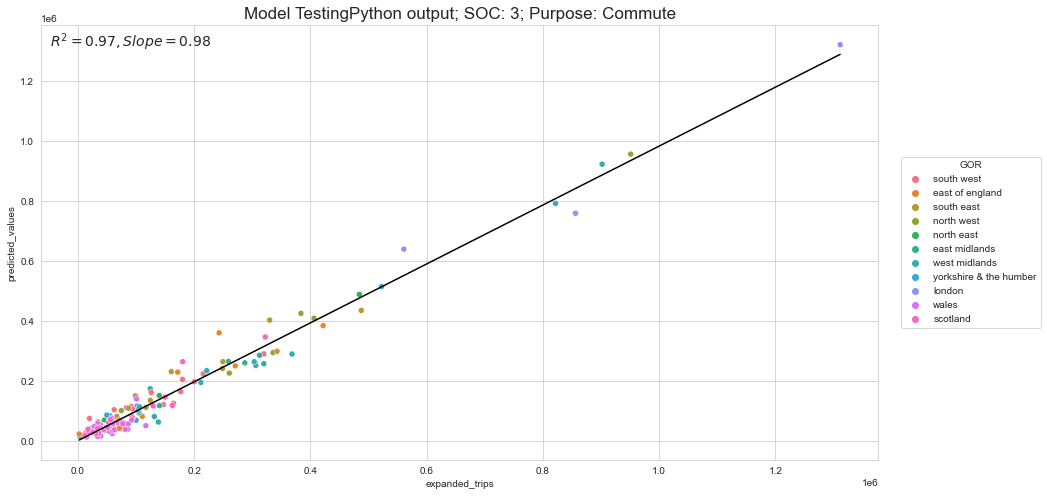

["Employer's Business1"]


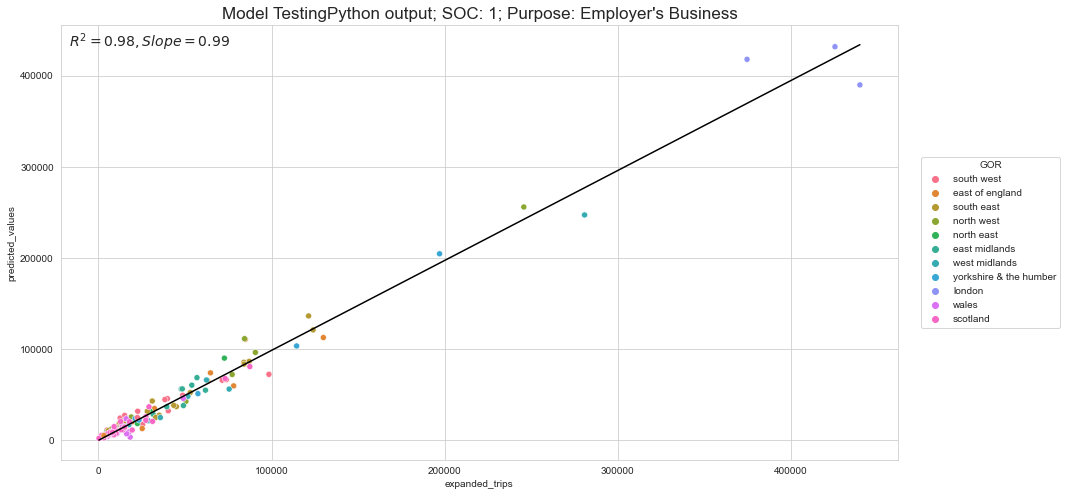

["Employer's Business2", "Employer's Business3"]


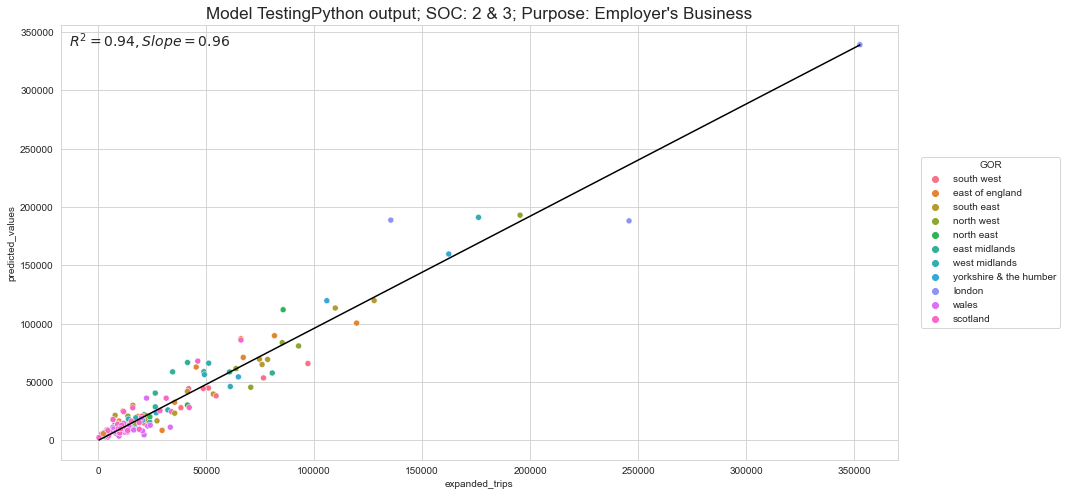

Education


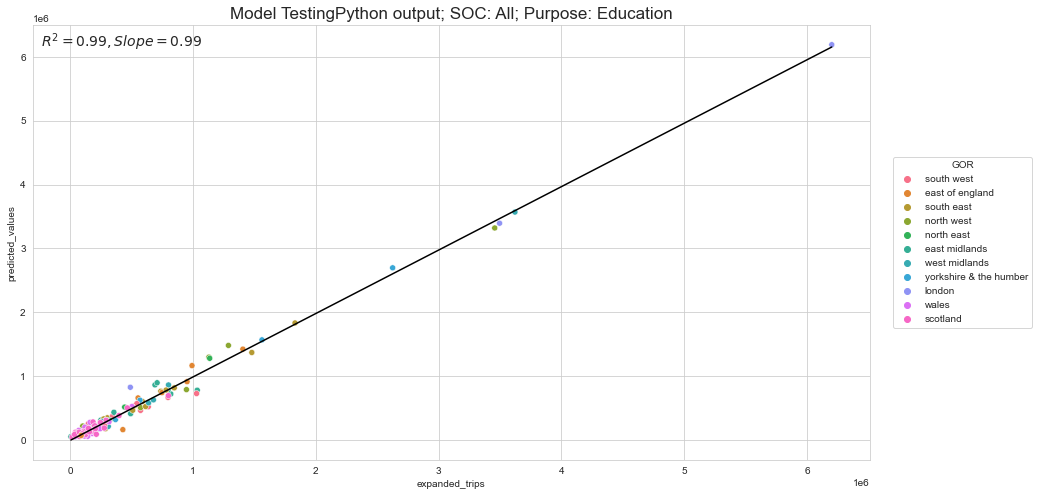

Shopping


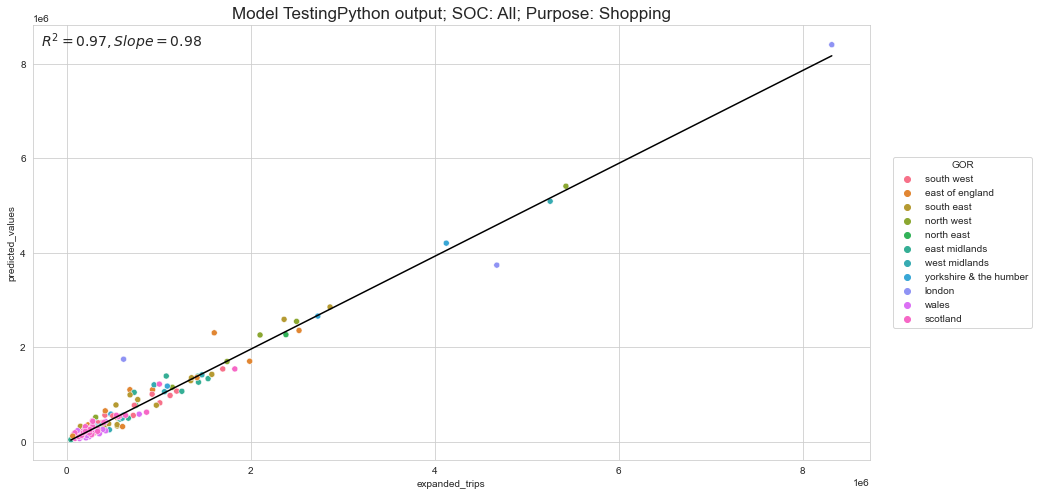

Personal Business


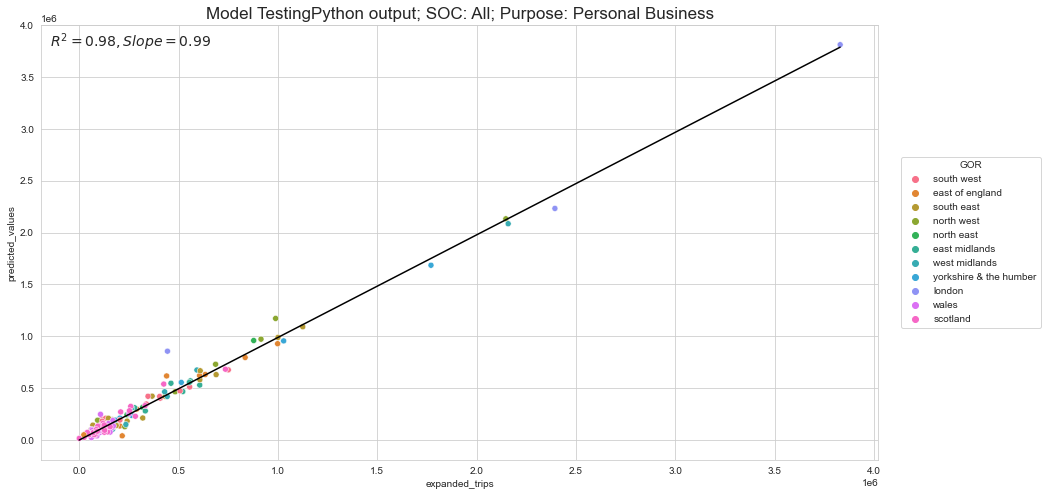

Visit Friend


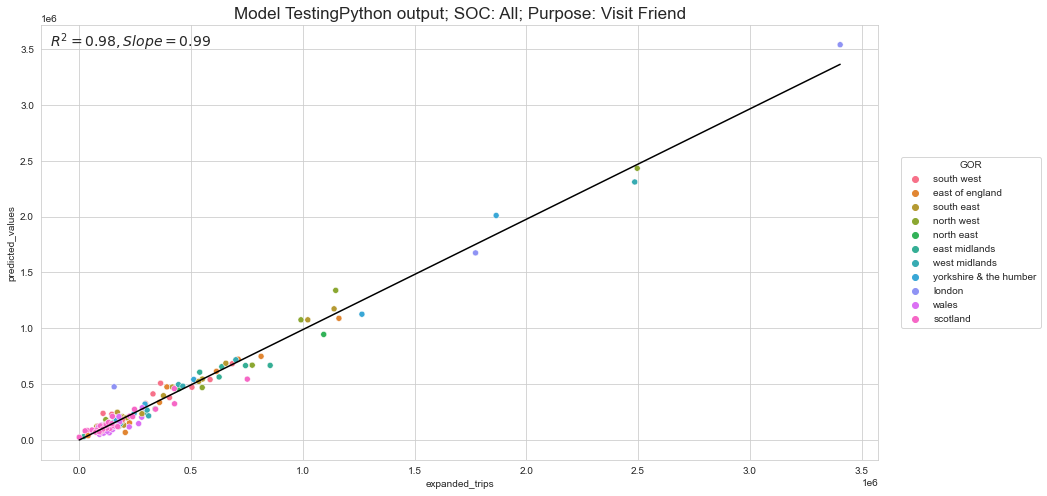

Holiday


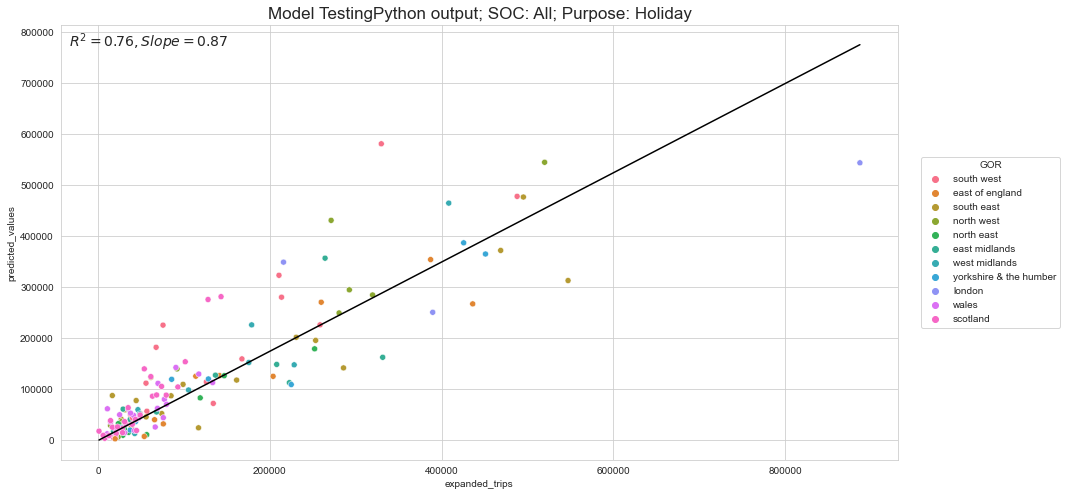

In [16]:
p_coeffs_list = []
for at_classification, purposes in at_purp_classifcation.items():
    correspondence_list_at = get_AT_grouping_table(at_classification)
    
    # Lookup tables dependent on Area Type grouping
    df_msoatoatlookup = df_msoatoatlookup_in.copy()
    df_msoatoatlookup['ATgroup'] = df_msoatoatlookup['tfn_at'].map(correspondence_list_at)
    df_msoatoatlookup = df_msoatoatlookup[['msoa11cd', 'ATgroup']]

    df_socsic_atua = df_msoatoatlookup.rename(columns={'msoa11cd': 'msoa_zone_id'})
    df_socsic_atua = pd.merge(df_socsic, df_socsic_atua, on='msoa_zone_id', how='inner')
    df_socsic_atua = pd.merge(df_socsic_atua, df_msoaUAlookup, on='msoa_zone_id', how='inner')
    df_socsic_atua = df_socsic_atua[['sic_2d', 'soc_class','seg_jobs','ATgroup', 'ua_1998_zone_id']]
    
    # Loop through purposes and what they correpsond to
    for p in purposes:
        if purpose_inclusion[p] == 'On':
            purpose_vals = correspondence_list_purpose[p]
            if p == 'Visit Friend':
                # Do Visit Friend - completely unrelated to employment, hence why it's done on its own
                titlesoc = 'All'
                
                # Get NTS data NTS
                df_for_reg = get_nts_formatted(df_nts, p, 'purpose_name')
                
                # Process hh/pop data
                for vf_data in purpose_vals:
                    # Attach TfN AT grouping to data
                    df_vf_trips = df_hhpop_trips.merge(df_msoatoatlookup, on='msoa11cd', how='inner')

                    # Pivoting
                    df_vf_trips = df_vf_trips.groupby(['ua_1998_zone_id', 'ATgroup'])[[vf_data]].sum().reset_index()
                    df_vf_trips = df_vf_trips.pivot_table(index=['ua_1998_zone_id'], columns=['ATgroup'],
                                                values=vf_data, aggfunc='sum').reset_index()
                    df_vf_trips.fillna(0, inplace=True)
                    # Loop through each column in the DataFrames
                    for col in df_vf_trips.columns:
                        # Check if it is the column to be excluded
                        if col != 'ua_1998_zone_id':
                            # Prefix the string to the column name
                            df_vf_trips.rename(columns={col: vf_data + '_' + col}, inplace=True)
                    
                    # Join to NTS
                    df_for_reg = df_for_reg.merge(df_vf_trips, on='ua_1998_zone_id', how='left')
                
                # Regressions and outputs
                print(p)
                reg_inputs_fname = '_'.join([model_name, model_version, p, titlesoc, 'data.csv'])
                df_for_reg.to_csv(os.path.join(modeldirpath, reg_inputs_fname), index=False)
                p_coeffs = regressions(df_for_reg, titlesoc, p)
                p_coeffs_list.append([p_coeffs, p, titlesoc])
                    
            else:
                # First, get the purpose_vals sorted by what they apply to (employment data, education data, etc.)
                edu_vals = []
                sic_vals = []
                if purpose_vals == 'All_SICs':
                    sic_vals = 'All' # Force the list to become a string (len will still be > 0)
                else:
                    for v in purpose_vals:
                        if v in range(1, 100):
                            sic_vals.append(v)
                        elif type(v) is list:
                            if all(isinstance(x, int) for x in v) == True:
                                   sic_vals.append(v)
                        elif v in pupil_education:
                            edu_vals.append(v)
                        else:
                            print(f'WARNING! - When processing purpose {p}, within the values, found unexpected input: {str(v)}')
                            print(f'   - Did not process: {str(v)}')

                # Now process data by purpose under the various selection conditions
                if p in purposes_with_soc_selection:
                    # Case where purpose is disagregated by SOC
                    # Education data NOT processed here as it cannot be disaggregated by SOC 
                    for soc_val in purposes_with_soc_selection[p]:
                        psocs = []
                        if type(soc_val) is list:
                            soc_val = sorted(soc_val)
                            for socv in soc_val:
                                psocs.append(''.join([p, str(socv)]))
                            titlesoc = ' & '.join(map(str, soc_val))
                            if titlesoc == '1 & 2 & 3 & 4':
                                titlesoc = 'All'
                        else:
                            psocs.append(''.join([p, str(soc_val)]))
                            titlesoc = str(soc_val)
                        if len(sic_vals) > 0:
                            df_for_reg = all_purpose_sics(p, psocs, sic_vals, df_socsic_atua)
                        print(psocs)
                        reg_inputs_fname = '_'.join([model_name, model_version, p, titlesoc, 'data.csv'])
                        df_for_reg.to_csv(os.path.join(modeldirpath, reg_inputs_fname), index=False)
                        p_coeffs = regressions(df_for_reg, titlesoc, p)
                        p_coeffs_list.append([p_coeffs, p, titlesoc])
                else:
                    reg_sel = 0
                    if len(sic_vals) > 0:
                        df_for_reg_sic = all_purpose_sics(p, p, sic_vals, df_socsic_atua)
                        reg_sel = reg_sel + 1

                    # Process education data
                    if len(edu_vals) > 0:
                        edu_dfs = []
                        for level in edu_vals:
                            puprefix = 'Main_edu_students'
                            feprefix = 'Further_edu_students'
                            heprefix = 'Higher_edu_students'
                            if level == 'pupil':
                                edu_dfs.append(process_edu_by_level(df_pupilGB, puprefix))
                            elif level == 'further':
                                edu_dfs.append(process_edu_by_level(df_feGB, feprefix))
                            elif level == 'higher':
                                edu_dfs.append(process_edu_by_level(df_highereduGB, heprefix))
                            else:
                                print(
                                    f'WARNING! - Expected education level to be "pupil", "further" or "higher", but got {str(level)}'
                                )
                        reg_sel = reg_sel + 2
                        # - TODO: look at options in input on how to combine levels of education
                        if len(edu_dfs) > 1:
                            if (pupil_aggregation == False) & (edu_aggregation == False):
                                df_for_reg_edu = pd.concat(edu_dfs, axis=1)
                                df_for_reg_edu = df_for_reg_edu.fillna(0)
                            else:
                                for edu_df in edu_dfs:
                                    # Rename columns to remove prefixes
                                    edu_df.columns = [col.lstrip(puprefix) for col in edu_df.columns]
                                    edu_df.columns = [col.lstrip(feprefix) for col in edu_df.columns]
                                    edu_df.columns = [col.lstrip(heprefix) for col in edu_df.columns]

                                    # sum dfs on maximal (but ideally same) row count, same columns
                                    df_for_reg_edu = pd.concat(
                                        edu_dfs).fillna(0).groupby(['ua_1998_zone_id']).sum()

                                    # Rename columns
                                    columns_to_prefix = [col for col in df_for_reg_edu.columns if col != 'ua_1998_zone_id']
                                    prefixed_columns = [f'All_Selected_Students_{col}' for col in columns_to_prefix]
                                    new_columns = {
                                        old_col: new_col for old_col, new_col in zip(columns_to_prefix, prefixed_columns)}
                                    df_for_reg_edu = df_for_reg_edu.rename(columns=new_columns)      
                        else:
                            df_for_reg_edu = edu_dfs[0].copy()

                    # Combine edu and sic dfs if both not empty here, otherwise take the non-empty df
                    if reg_sel == 1:
                        df_for_reg = df_for_reg_sic.copy()
                    elif reg_sel == 2:
                        df_for_reg = df_for_reg_edu.reset_index()
                        # Get the NTS data in this case as the employment data will not pick it up for us
                        df_nts_edu = get_nts_formatted(df_nts, p, 'purpose_name')
                        df_for_reg = df_nts_edu.merge(df_for_reg, on='ua_1998_zone_id', how='left')
                    elif reg_sel == 3:
                        df_for_reg = df_for_reg_sic.set_index('ua_1998_zone_id')
                        if edu_aggregation == False:
                            # Append dfs to each other - maximal (but ideally same) row count, adding columns
                            df_for_reg = df_for_reg_sic.merge(df_for_reg_edu, how='outer', on='ua_1998_zone_id')
                            df_for_reg = df_for_reg.fillna(0)
                        else:
                            # Rename columns to remove prefixes
                            df_for_reg_edu.columns = [col.lstrip(puprefix) for col in df_for_reg_edu.columns]
                            df_for_reg_edu.columns = [col.lstrip(feprefix) for col in df_for_reg_edu.columns]
                            df_for_reg_edu.columns = [col.lstrip(heprefix) for col in df_for_reg_edu.columns]
                            df_for_reg_edu.columns = [col.lstrip('All_Selected_Students') for col in df_for_reg_edu.columns]
                            df_for_reg.columns = ['_'.join(['Group', col.split('_')[-1]]) for col in df_for_reg.columns]
                            df_for_reg.columns = [col.replace('Group_trips', 'expanded_trips') for col in df_for_reg.columns]

                            # Split expanded trips off into its own df for merging
                            df_exptrips = df_for_reg[['expanded_trips']]#.set_index('ua_1998_zone_id')
                            df_for_reg.drop(columns=['expanded_trips'], axis=1, inplace=True)

                            # sum dfs on maximal (but ideally same) row count, same column
                            df_for_reg = pd.concat(
                                [df_for_reg, df_for_reg_edu]).groupby(['ua_1998_zone_id']).sum()
                            df_for_reg = pd.concat([df_exptrips, df_for_reg], axis=1)

                            # Rename columns
                            columns_to_prefix = [col for col in df_for_reg_edu.columns if col != 'ua_1998_zone_id']
                            prefixed_columns = [f'All_Students_{col}' for col in columns_to_prefix]
                            new_columns = {
                                old_col: new_col for old_col, new_col in zip(columns_to_prefix, prefixed_columns)}
                            df_for_reg_edu = df_for_reg_edu.rename(columns=new_columns) 
                    else:
                        print('WARNING! - Unclear how to process merger of employment and education data')

                    titlesoc = 'All'
                    print(p)
                    reg_inputs_fname = '_'.join([model_name, model_version, p, 'data.csv'])
                    df_for_reg.to_csv(os.path.join(modeldirpath, reg_inputs_fname), index=False)
                    p_coeffs = regressions(df_for_reg, titlesoc, p)
                    p_coeffs_list.append([p_coeffs, p, titlesoc])

pcs = []
for pcl in p_coeffs_list:
    pc = pcl[0]
    p = pcl[1]
    s = pcl[2]
    pc['Purpose'] = p
    pc['Feature'] = pc['Feature'].str.replace('Group_', '')
    pc.insert(len(pc.columns)-1, 'TfN Area Types', pc.pop('Feature'))
    pc['SOC'] = s
    pc['Selection - SIC code or data'] = pc['TfN Area Types'].str.split('_').str[0]
    pc['TfN Area Types'] = pc['TfN Area Types'].str.split('_').str[1]
    pc['TfN Area Types'] = pc['TfN Area Types'].str.split(',')
    pc = pc.explode('TfN Area Types')
    pc['TfN Area Types'] = pc['TfN Area Types'].astype(int)
    pc.insert(len(pc.columns)-1, 'Coefficient', pc.pop('Coefficient'))
    pcs.append(pc)

all_coeffs = pd.concat(pcs, axis=0, ignore_index=True)
ac_fname = '_'.join([model_name, model_version, 'all_coeffs.csv'])
all_coeffs.to_csv(os.path.join(modeldirpath, ac_fname), index=False)

## Scratch area

In [17]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# To use the Ridge regression model with positive coefficients only, we need a later version of scikit-learn installing.
# I have tried this but can't get anything in anaconda to update

The scikit-learn version is 0.24.1.
